In [1]:
# import libraries

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display



In [2]:
# read data

df_final=pd.read_csv('data/data_cleaned.csv')
df_final.head()


,Unnamed: 0,track_id,album_comments,album_date_created,album_favorites,album_id,album_listens,album_title,album_tracks,album_type,...,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01,other_website,soundcloud_website,track_title_char_count,album_information_bin,artist_bio_bin
0,0,2,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,...,0.085629,0.071289,0.000000,2.089872,0.061448,True,False,4,1,1
1,1,5,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,...,0.053114,0.041504,0.000000,2.193303,0.044861,True,False,10,1,1
2,2,10,0,2008-11-26 01:45:08,4,6,47632,Constant Hitmaker,2,Album,...,0.077515,0.071777,0.000000,3.542325,0.040800,True,False,7,0,1
3,3,140,1,2008-11-26 01:49:59,1,61,1300,The Blind Spot,1,Album,...,0.052379,0.036621,0.001953,3.143968,0.057712,True,False,18,1,1
4,4,141,0,2008-11-26 01:49:57,1,60,1304,Every Man For Himself,2,Album,...,0.040267,0.034668,0.002930,4.204097,0.028665,True,False,4,1,1


In [24]:
# check possible target variable

df_final['track_listens'].describe().round(2)

count      8000.00
mean       4729.68
std       12222.02
min         196.00
25%        1266.00
50%        2492.50
75%        4900.25
max      543252.00
Name: track_listens, dtype: float64

<Axes: xlabel='months_life', ylabel='Count'>

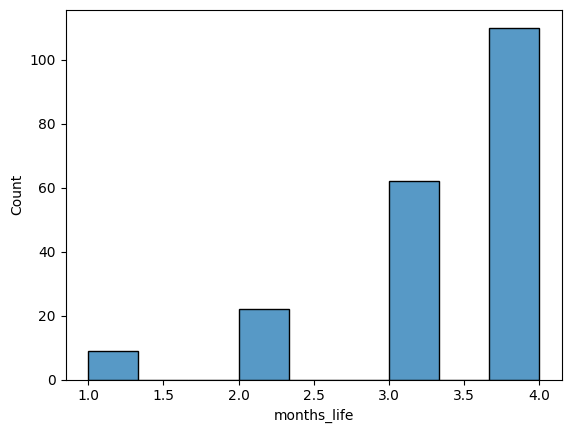

In [25]:
# analyse 'new' tracks
df_final['track_date_created'] = pd.to_datetime(df_final['track_date_created'])
target_date = pd.to_datetime('2017-04-01')
df_final['months_life'] = ((target_date.year - df_final['track_date_created'].dt.year) * 12 +
                          (target_date.month - df_final['track_date_created'].dt.month))

sns.histplot(data=df_final[df_final['months_life']<5],x='months_life')

<Axes: xlabel='months_life', ylabel='track_listens'>

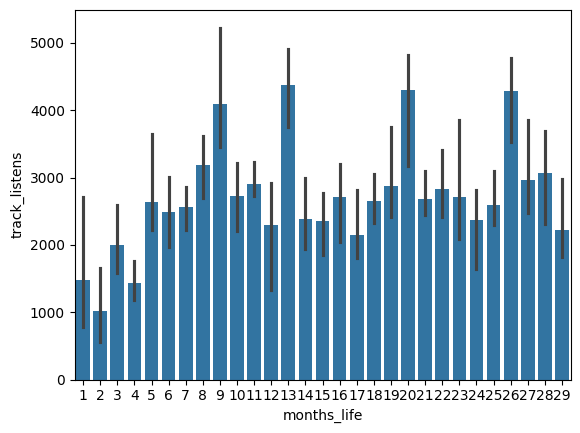

In [5]:
# development of listens depending on track "age", as of month 5 almost stable number of listens

df_final.groupby('months_life')['track_listens'].median()
sns.barplot(data=df_final[df_final['months_life']<30],x='months_life',y='track_listens',estimator='median')

In [6]:
# listens per month, calculation of quartiles for bonus class definition and amount of bonus given

df_final['listens_month']=df_final['track_listens']/df_final['months_life']
df_final[df_final['months_life']<20].groupby('months_life')['listens_month'].median()

#df_final[df_final['months_life']==1]['listens_month'].describe()
#df_final[df_final['months_life']==2]['listens_month'].describe()
#df_final[df_final['months_life']==3]['listens_month'].describe()
#df_final[df_final['months_life']==4]['listens_month'].describe()
#df_final[df_final['months_life']==5]['listens_month'].describe()
#df_final[df_final['months_life']==1]['track_listens'].describe()
#df_final[df_final['months_life']==2]['track_listens'].describe()
#df_final[df_final['months_life']==3]['track_listens'].describe()
#df_final[df_final['months_life']==4]['track_listens'].describe()

months_life
1     1474.000000
2      511.250000
3      664.666667
4      360.375000
5      527.200000
6      415.333333
7      365.571429
8      398.000000
9      454.833333
10     273.250000
11     263.636364
12     191.208333
13     336.538462
14     170.785714
15     157.500000
16     169.937500
17     126.352941
18     147.444444
19     151.473684
Name: listens_month, dtype: float64

In [7]:
# Function to calculate bonus_listens, tracks which started successful get higher bonus for month 2,3,4 and 5 based on quartiles above

def calculate_bonus(row):
    if row['months_life'] == 1:
        if row['track_listens'] < 1312:
            return 168 + 157 + 102 + 158
        elif 1312 <= row['track_listens'] < 1474:
            return 280 + 432 + 217 + 338
        elif 1474 <= row['track_listens'] < 1835:
            return 511 + 664 + 360 + 527
        else:
            return 938 + 1070 + 686 + 885
    elif row['months_life'] == 2:
        if row['track_listens'] < 561:
            return 157 + 102 + 158
        elif 561 <= row['track_listens'] < 1023:
            return 432 + 217 + 338
        elif 1023 <= row['track_listens'] < 1875:
            return 664 + 360 + 527
        else:
            return 1070 + 686 + 885
    elif row['months_life'] == 3:
        if row['track_listens'] < 1296:
            return 102 + 158
        elif 1296 <= row['track_listens'] < 1994:
            return 217 + 338
        elif 1994 <= row['track_listens'] < 3209:
            return 360 + 527
        else:
            return 686 + 885
    elif row['months_life'] == 4:
        if row['track_listens'] < 868:
            return 158
        elif 868 <= row['track_listens'] < 1441:
            return 338
        elif 1441 <= row['track_listens'] < 2702:
            return 527
        else:
            return 885


In [8]:
# Apply function and add it to original listens

df_final['bonus_listens'] = df_final.apply(calculate_bonus, axis=1)

df_final['bonus_listens'].fillna(0, inplace=True)
df_final['listens_incl_bonus']=df_final['track_listens']+df_final['bonus_listens']


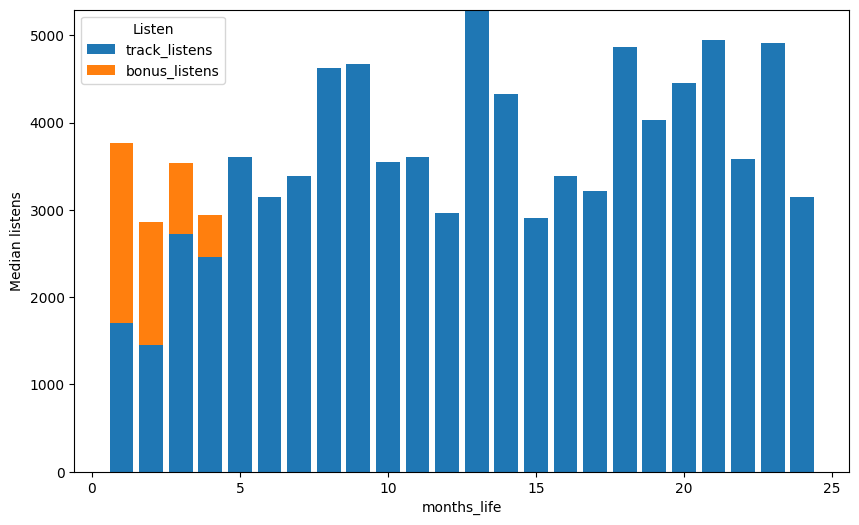

In [9]:
# plot bonus and original listens

filtered_data = df_final[df_final['months_life'] < 25]
grouped_data = filtered_data.groupby('months_life')[['track_listens', 'bonus_listens']].mean()

plt.figure(figsize=(10, 6))
bottom = None
for column in grouped_data.columns:
    plt.bar(grouped_data.index, grouped_data[column], label=column,bottom=bottom)
    if bottom is None:
        bottom = grouped_data[column]
    else:
        bottom += grouped_data[column]
plt.xlabel('months_life')
plt.ylabel('Median listens')
plt.legend(title='Listen')
plt.show()

In [10]:
# calculation conversion rate needs to be based on adjusted listens AND interest

#df_final['combi']=df_final['listens_incl_bonus']/df_final['track_interest']
#df_final['pop_score']=df_final['combi']*df_final['listens_incl_bonus']

<Axes: xlabel='listens_incl_bonus', ylabel='Count'>

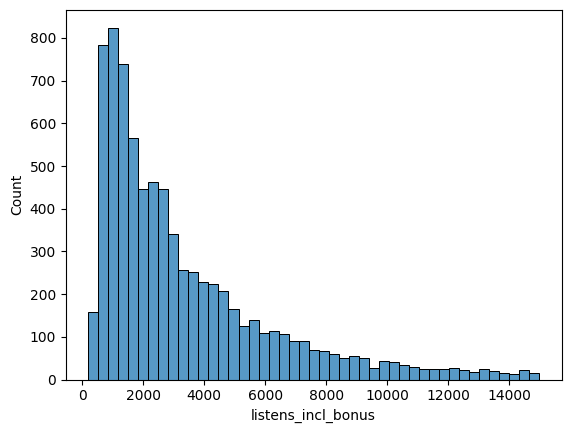

In [11]:
df_final_15 = df_final[df_final['listens_incl_bonus']<15000]
sns.histplot(data=df_final_15,x='listens_incl_bonus')

In [12]:
# print bin edges for 4 balanced bins of track listens incl. bonus

results, bin_edges= pd.qcut(df_final['listens_incl_bonus'], q=4,retbins=True)
print(bin_edges)

[1.96000e+02 1.27375e+03 2.50550e+03 4.93700e+03 5.43252e+05]


In [13]:
# create 5 bins for listens incl. bonus with customized edges
custom_bins = [0, 1250, 2500, 5000, float('inf')]
df_final['listens_bins'] = pd.cut(df_final['listens_incl_bonus'], bins=custom_bins, labels=range(1,5))
df_final['listens_bins'].value_counts()

listens_bins
2    2054
3    2053
4    1960
1    1933
Name: count, dtype: int64

In [14]:
# check bins against genre for baseline model

pd.crosstab(df_final['track_genre_top'],df_final['listens_bins'])

listens_bins,1,2,3,4
track_genre_top,,,,
Electronic,0,2,239,759
Experimental,426,357,146,71
Folk,531,291,119,59
Hip-Hop,91,494,268,147
Instrumental,0,187,391,422
International,381,261,194,164
Pop,503,294,137,66
Rock,1,168,559,272


In [15]:
# genre = category

print(df_final['track_genre_top'].dtype)
df_final['track_genre_top'] = df_final['track_genre_top'].astype('category')

object


In [16]:
# Baseline model genre mapping, create prediction variable

genre_mapping = {
    'Rock': 4,
    'Pop': 1,
    'Folk': 1,
    'Hip-Hop': 1,
    'Instrumental': 4,
    'Electronic': 4,
    'Experimental': 1,
    'International': 1}


df_final['genre_pred'] = df_final['track_genre_top'].replace(genre_mapping)

In [17]:
df_final['genre_pred'] = df_final['genre_pred'].astype('int')

In [18]:
pd.crosstab(df_final['listens_bins'],df_final['genre_pred'])

genre_pred,1,4
listens_bins,,
1,1932,1
2,1697,357
3,864,1189
4,507,1453


In [19]:
# performance basemodel, correct classes and cohen's kappa

from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

y_pred = df_final['genre_pred']
y_true = df_final['listens_bins']


conf_matrix= confusion_matrix(y_true, y_pred)
accurate_classes = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])
off_by_one = sum([conf_matrix[i][j] if abs(i - j) == 1 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_two = sum([conf_matrix[i][j] if abs(i - j) == 2 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_three = sum([conf_matrix[i][j] if abs(i - j) == 3 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
#off_by_four = sum([conf_matrix[i][j] if abs(i - j) == 4 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])

print((100*accurate_classes/conf_matrix.sum()).round(1))
print((100*off_by_one/conf_matrix.sum()).round(1))
print((100*off_by_two/conf_matrix.sum()).round(1))
print((100*off_by_three/conf_matrix.sum()).round(1))
#print((100*off_by_four/conf_matrix.sum()).round(1))
print('--------------------------------')
print(cohen_kappa_score(y_true, y_pred).round(3))

42.3
36.1
15.3
6.4
--------------------------------
0.238


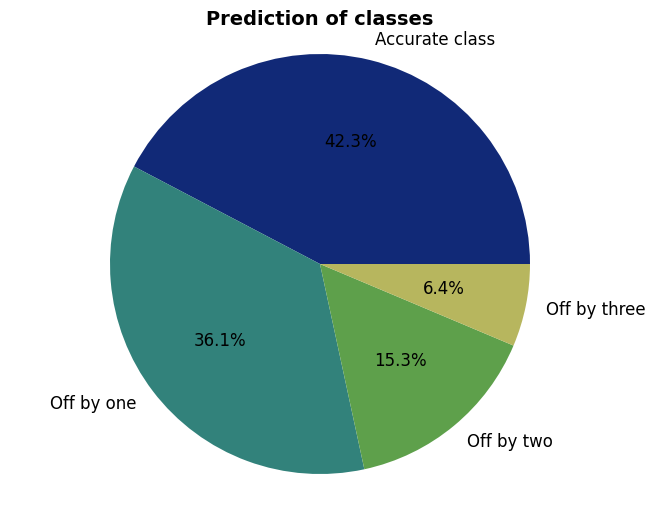

In [20]:
# Plot of performance

import matplotlib.pyplot as plt

labels = ['Accurate class', 'Off by one', 'Off by two','Off by three']
sizes = [accurate_classes, off_by_one, off_by_two,off_by_three]
colors= plt.cm.gist_earth([0.1,0.3,0.5,0.7,0.9])

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels,colors=colors ,autopct='%1.1f%%', textprops={'fontsize': 12})
plt.title('Prediction of classes',fontsize=14, fontweight='bold')
plt.axis('equal') 
plt.show()

In [23]:
df_final.to_csv('data/data_with_target.csv', index=False)